In [0]:
# Importing the Keras libraries and packages
import tensorflow as tf
# from tensorflow.python.keras.models import Sequential
import tensorflow.keras
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.models import load_model, model_from_yaml
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import IPython.display as display
from pathlib import Path
import numpy as np
import datetime as dt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import os, sys, cv2, random, math, pickle, time

In [0]:
import os
try:
  from google.colab import drive 
  drive.mount("/content/drive")
  IN_COLAB = True
except:
  IN_COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%shell

## Source Path 
export GDRIVE_PROJ_PATH="/content/drive/My Drive/ITI110_Project/"
export LINK_PROJ_PATH="/content/"

echo $GDRIVE_PROJ_PAT
ln -s "$GDRIVE_PROJ_PATH" $LINK_PROJ_PATH

In [0]:
## Start To Change ##

BASE_DIR = '/content/ITI110_Project/' ## Change BASE_DIR if you using Windows. E.g. d:/ITI110_Project/
EXP_MODEL_DIR = '/content/ITI110_Project/models/base_models/Pilotnet_Elu_Adam_AUGMENT_202002231644/'
RAW_DATA_DIR  = os.path.join(BASE_DIR,'data','t2') ## Change Here
## End To Change ##

In [0]:
data_x = [] ## Input (224)
data_y = [] ## Label (motor left, motor right)
sample_size = 100
## Load data from raw data folder
## Data is split to 2 differant arrays

for obj in os.listdir(RAW_DATA_DIR):
  if obj.endswith('.npy'):
    data = np.load(os.path.join(RAW_DATA_DIR,obj),allow_pickle=True)
    data = data[((data[:,0] > 0.0) & (data[:,1] > 0.0))]
    print(f'Loaded : {obj} for {data.shape}' )
    data_x.extend(data[:,2])
    data_y.extend(data[:,0:2])

data_x = np.array(data_x)
data_y = np.array(data_y)
print(f'All Input: {data_x.shape} \t All Label: {data_y.shape}')

# Draw Random Sample

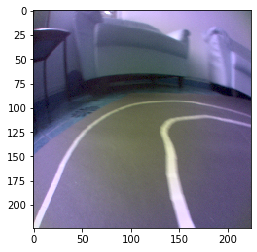

In [0]:
# Draw random picture
random_index = random.randrange(1, len(data_x), 1)
test_sample_x = data_x[random_index]

plt.imshow(test_sample_x[::])

# Canny Edge Detection

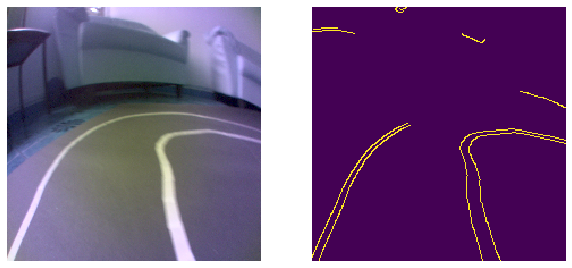

In [0]:
def detect_edges(image, low_threshold=200, high_threshold=400):
  return cv2.Canny(image, low_threshold, high_threshold)

#gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
#image = detect_edges(gray_image, low_threshold=50, high_threshold=150)
seg_image = cv2.cvtColor(test_sample_x, cv2.COLOR_BGR2GRAY)

#plt.imshow(gray_image, cmap='gray')
seg_image = detect_edges(seg_image, low_threshold=200, high_threshold=400)


fig, (p1, p2) = plt.subplots(1, 2, figsize=(10,10))
p1.imshow(test_sample_x)
p2.imshow(seg_image)
p1.axis('off')
p2.axis('off')

plt.savefig(os.path.join(EXP_MODEL_DIR,'edge-detection.png'))
plt.show()

# Region Of Interest

In [0]:
def region_of_interest(edges):
  height, width = edges.shape
  mask = np.zeros_like(edges)

  # only focus bottom half of the screen
  polygon = np.array([[
      (0, height * 1 / 2),
      (width, height * 1 / 2),
      (width, height),
      (0, height),
  ]], np.int32)

  cv2.fillPoly(mask, polygon, 255)
  cropped_edges = cv2.bitwise_and(edges, mask)
  return cropped_edges

  cropped = region_of_interest(seg_image)

plt.imshow(cropped)

## Wrapper Function: edge + roi

In [0]:
def detect_roi(image,low_threshold=200, high_threshold=400):
  '''
  detect region of interest
  '''
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  edges = detect_edges(image,low_threshold,high_threshold)
  roi = region_of_interest(edges)

  return roi


## Step by Step Demostration

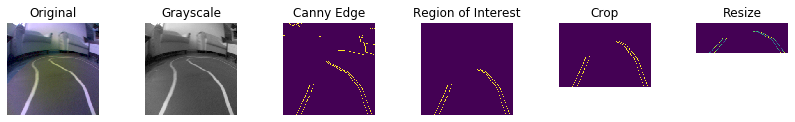

In [0]:
random_index = random.randrange(1, len(data_x), 1)
test_sample_x = data_x[random_index]

fig, (p1,p2,p3,p4, p5, p6) = plt.subplots(1,6, figsize=(14,8))
fig.subplots_adjust(wspace=0.5, hspace=0.4)
p1.imshow(test_sample_x)
p1.set_title('Original')

image = cv2.cvtColor(test_sample_x, cv2.COLOR_BGR2GRAY)
p2.imshow(image, cmap='gray')
p2.set_title('Grayscale')

image = detect_edges(image,200,400)
p3.imshow(image)
p3.set_title('Canny Edge')

p4.set_title('Region of Interest')
image = region_of_interest(image)
p4.imshow(image)

p5.set_title('Crop')
image = image[int(image.shape[0]*0.3):,:]
p5.imshow(image)

p6.set_title('Resize')
image = cv2.resize(image, (200,66))
p6.imshow(image)

p1.axis('off')
p2.axis('off')
p3.axis('off')
p4.axis('off')
p5.axis('off')
p6.axis('off')
p1.set_anchor('N')
p2.set_anchor('N')
p3.set_anchor('N')
p4.set_anchor('N')
p5.set_anchor('N')
p6.set_anchor('N')

plt.savefig(os.path.join(EXP_MODEL_DIR,'lane-masking.png'),orientation='landscape')
plt.show()

In [0]:
def detect_line_segments(cropped_edges):
  
  rho = 1  # distance precision in pixel, i.e. 1 pixel
  angle = np.pi / 180  # angular precision in radian, i.e. 1 degree
  min_threshold = 10  # minimal of votes
  line_segments = cv2.HoughLinesP(cropped_edges, rho, angle, min_threshold, 
                                  np.array([]), minLineLength=8, maxLineGap=4)

  return line_segments

In [0]:
def make_points(frame, line):
  height, width, _ = frame.shape
  slope, intercept = line
  y1 = height  # bottom of the frame
  y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

  # bound the coordinates within the frame
  x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
  x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
  return [[x1, y1, x2, y2]]

In [0]:
def average_slope_intercept(frame, line_segments):
  """
  This function combines line segments into one or two lane lines
  If all line slopes are < 0: then we only have detected left lane
  If all line slopes are > 0: then we only have detected right lane
  """
  lane_lines = []
  if line_segments is None:
      logging.info('No line_segment segments detected')
      return lane_lines

  height, width, _ = frame.shape
  left_fit = []
  right_fit = []

  boundary = 1/3
  left_region_boundary = width * (1 - boundary)  # left lane line segment should be on left 2/3 of the screen
  right_region_boundary = width * boundary # right lane line segment should be on left 2/3 of the screen

  for line_segment in line_segments:
      for x1, y1, x2, y2 in line_segment:
          if x1 == x2:
              #logging.info('skipping vertical line segment (slope=inf): %s' % line_segment)
              continue
          fit = np.polyfit((x1, x2), (y1, y2), 1)
          slope = fit[0]
          intercept = fit[1]
          if slope < 0:
              if x1 < left_region_boundary and x2 < left_region_boundary:
                  left_fit.append((slope, intercept))
          else:
              if x1 > right_region_boundary and x2 > right_region_boundary:
                  right_fit.append((slope, intercept))

  left_fit_average = np.average(left_fit, axis=0)
  if len(left_fit) > 0:
      lane_lines.append(make_points(frame, left_fit_average))

  right_fit_average = np.average(right_fit, axis=0)
  if len(right_fit) > 0:
      lane_lines.append(make_points(frame, right_fit_average))

  #logging.debug('lane lines: %s' % lane_lines)  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

  return lane_lines

## Wrapper Function - get lane lines coordinates

In [0]:
def detect_lane(frame):
    
  edges = detect_edges(frame)
  cropped_edges = region_of_interest(edges)
  line_segments = detect_line_segments(cropped_edges)
  lane_lines = average_slope_intercept(frame, line_segments)

  return lane_lines

# Display Lane Line

In [0]:
def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
  line_image = np.zeros_like(frame)
  if lines is not None:
      for line in lines:
          for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
  line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
  return line_image

Testing

(224, 224, 3)


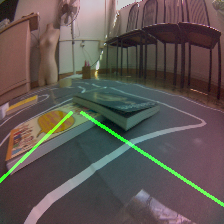

In [0]:
lane_lines = detect_lane(test_sample_x)
lane_lines_image = display_lines(test_sample_x, lane_lines)
print(lane_lines_image.shape)
cv2_imshow(lane_lines_image)

# Display heading lines (1 lane detected)


In [0]:
def display_heading_1line(frame,lane_lines, line_color=(0, 0, 255), line_width=5 ):
  heading_image = np.zeros_like(frame)
  height, width, _ = frame.shape
  
  x1, _, x2, _ = lane_lines[0][0]
  x_offset = x2 - x1
  y_offset = int(height / 2)
  x1 = int(width / 2)
  y1 = height
  cv2.line(heading_image, (x1, y1), (x_offset, y_offset), line_color, line_width)
  heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

  return heading_image

# Display heading lines (2 lanes detected)

In [0]:
def display_lines_w_headlines(frame, line_color=(0, 255, 0), line_width=2):

  height, width, _ = frame.shape
  lines = detect_lane(frame)
  line_image = np.zeros_like(frame)
  if lines is not None:
      for line in lines:
          for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
  
  # headline direction
  if len(lines) == 1: ## 1 lane
    x1, _, x2, _ = lines[0][0]
    x_offset = x2 - x1
    y_offset = int(height / 2)
  else:
    _, _, left_x2, _ = lines[0][0]
    _, _, right_x2, _ = lines[1][0]
    mid = int(width / 2)
    x_offset = (left_x2 + right_x2) / 2 #- mid
    y_offset = int(height / 2)
  
  # headline starting point
  x1 = int(width / 2)
  y1 = height

  cv2.line(line_image, (x1, y1), (int(x_offset), y_offset), (0, 0, 255), 5)
  
  line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)

  return line_image

Testing

In [0]:
#random_index = random.randrange(1, len(data_x), 1)
test_sample_x = data_x[random_index]
lane_lines_image = display_lines_w_headlines(test_sample_x)
cv2_imshow(lane_lines_image)